# Common imports

In [1]:
import re,os
import numpy as np
import pandas as pd
from glob import glob
import sklearn
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from skimage.transform import rotate
from sklearn import tree
from sklearn.metrics import mean_squared_error
import matplotlib.image as mpimg
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,AutoMinorLocator

# Constants

In [2]:
SHP=(30,30,3)
BAND_ORDER=[2,0,1]
BANDS=["F814W","F125W","F160W"]

# Data Processing Functions

In [3]:
def rescale(a):
    a=a-a.min()
    a=a/a.max()
    return a

def get_angle(d):
    fit=PCA(n_components=2).fit(
        np.argwhere(d>=np.quantile(d,.75)))
    return np.arctan2(*fit.components_[0])

def rotation(d):
    fl=np.apply_along_axis(max,2,d.reshape(SHP))
    angle=get_angle(fl)
    for i in range(0,d.shape[2]):
        d[:,:,i]=rotate(d[:,:,i],
                        angle/np.pi*180-90,
                        clip=True)
    return d

def normalise_all(a,lower_q,upper_q):
    a=a.copy()
    x=SHP[0]*SHP[1]
    L,U=np.quantile(a,[lower_q,upper_q])
    a=np.clip(a,L,U)
    for i in range(0,len(a)):
        d=a[i,:].reshape(SHP)
        d=rotation(d)
        a[i,:]=d.flatten()
    return a

def get_data():
    L=[]
    def f(x): return re.search("[^/]+(?=.npy)",x)[0]
    fns=[x for x in map(f,glob("CANDELS/*.npy"))]
    skip=[]
    for fn in fns:
        x=np.load("CANDELS/%s.npy" % fn,allow_pickle=True)
        skip.append(any([x[:,:,i].max()==0 for i in range(0,SHP[2])]))
        L.append(x.flatten())
    a=np.row_stack(L)
    I=(a.std(axis=1)!=0) & ~(np.array(skip))
    return a[I],np.array(fns)[I]

def get_catalog():
    def f(x): return re.search("[^/]+(?=.npy)",x)[0]
    fns=[x for x in map(f , glob("CANDELS/*.npy"))]
    cat=pd.read_csv("CANDELS/catalog.csv")
    cat=cat[cat.ID.isin(fns)]
    cat=cat.sort_values("ID")
    cat=cat.reset_index(drop=True)
    return cat


# Image Generation

In [20]:
import matplotlib.image as mpimg

def make_image(I,figsize):
    L=[]
    for i in I.flatten():
        id=re.search("[0-9]+",i)[0].zfill(5)
        fn="GDS_RGBs/GDS_%s.png" % id
        if os.path.exists(fn): L.append(mpimg.imread(fn))
    fig=plt.figure(figsize=figsize)
    grid=ImageGrid(fig,111,nrows_ncols=figsize,axes_pad=0)
    for ax, im in zip(grid,L):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(im)
    plt.tight_layout()
    return plt

# Data

In [5]:
raw_data,indexes=get_data()
norm_data=normalise_all(raw_data,0,.99)
print("size",len(raw_data))

size 10243


# PCA

In [6]:
pca=PCA(.96).fit(norm_data)
scores=pca.transform(norm_data)
lik=pca.score_samples(norm_data)
print(pca.n_components_)

12


# Outlier Detection

/home/nodeuser/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app
/home/nodeuser/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


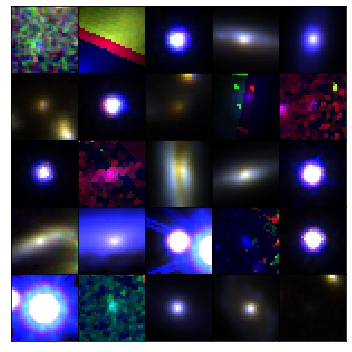

In [21]:
P=make_image(indexes[np.argsort(lik)][0:25],(5,5))
P.tight_layout()
#P.savefig("most-rare.png")
P.show()

# Sample size, eigengalaxies, and explained variance contour plot

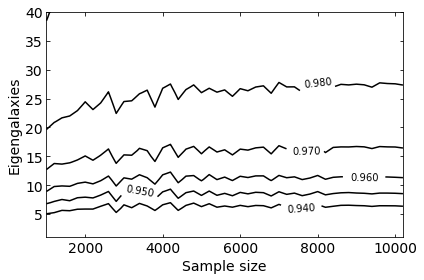

In [16]:
L=[]
pca_n=40
for s in range(1000,10400,200):
    idx=np.random.choice(range(0,len(norm_data)),s,replace=False)
    for r in range(0,100):
        p=PCA(pca_n).fit(norm_data[idx])
        for n in range(0,pca_n):
            L.append(dict(n=n,s=s,r=r,v=np.cumsum(p.explained_variance_ratio_)[n]))
X=pd.DataFrame(L)
X.n=X.n+1
X=X.groupby(["s","n"]).median()
X=X.reset_index()
del X["r"]
X=X.pivot('s', 'n')
x=X.columns.levels[1].values
y=X.index.values
z=X.values
Xi,Yi = np.meshgrid(x, y)
lvls=[.94,.95,.96,.97,.98,.99]
xx=plt.contour(Yi,Xi,z,levels=lvls,colors="black")
xx.clabel(xx.levels)
plt.ylabel("Eigengalaxies", fontsize=14)
plt.xlabel("Sample size", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
plt.tight_layout()
#plt.savefig("pca-over-samples.pdf")
plt.show()

# Cumulative sum of explained variance.

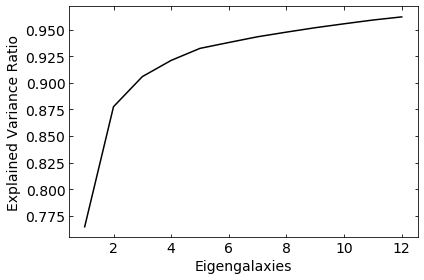

In [7]:
plt.plot(range(1,pca.n_components_+1),
         np.cumsum(pca.explained_variance_ratio_),
         color="black")
plt.ylabel("Explained Variance Ratio", fontsize=14)
plt.xlabel("Eigengalaxies", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
plt.tight_layout()
#plt.savefig("cum-var.pdf")
plt.show()

# Reconstruction Error

0.9961906622387185


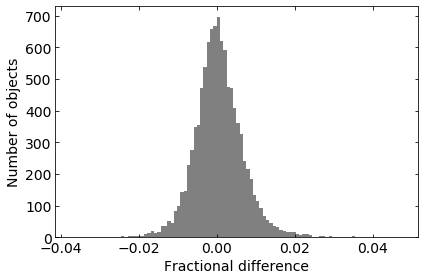

In [23]:
recon_data=np.dot(scores,pca.components_)+pca.mean_
idx=(norm_data!=0)
sm=norm_data.sum(axis=1)
df=(norm_data-recon_data).sum(axis=1)
sse=df/sm
sse=sse[(sse<=.05) & (sse>=-.05)]
print(((sse>=-.025) & (sse<=.025)).sum() / len(sse))
plt.hist(sse,color="gray",bins=100)
plt.xlabel("Fractional difference", fontsize=14)
plt.ylabel("Number of objects", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in",which='minor')
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
plt.tight_layout()
#plt.savefig("flux-diff-hist.pdf")
plt.show()

# The Eigengalaxies

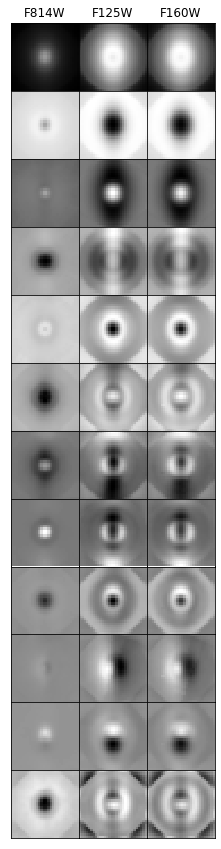

In [9]:
L=[]
N=pca.n_components_
for i in range(0,N):
    comp=pca.components_[i]
    comp=comp.reshape(SHP)
    mn=comp.min();mx=comp.max()
    for j in BAND_ORDER: L.append((mn,mx,comp[:,:,j]))
fig=plt.figure(figsize=(N,3*5))
grid=ImageGrid(fig,111,nrows_ncols=(N,3),axes_pad=0)
for i,b in enumerate(BANDS): grid[i].set_title(b)
for ax, tup in zip(grid,L):
    ax.set_xticks([])
    ax.set_yticks([])
    mn,mx,im=tup
    ax.imshow(im,cmap="gray", aspect="auto",vmin=mn,vmax=mx)
#plt.savefig("components.png")
plt.show()

# Random Forest Classification

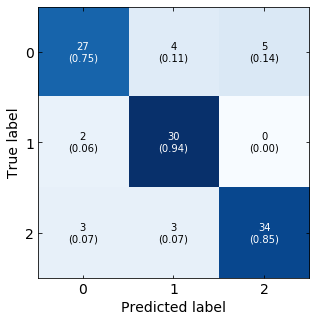

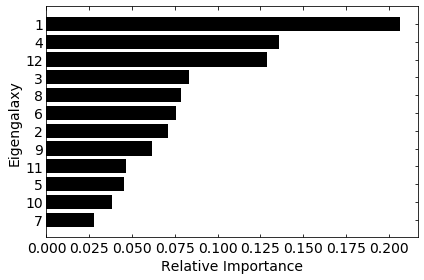

In [75]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import pretty

cat=get_catalog()

np.random.seed(1)

#EDGE ON
edgeon=cat[cat.clean_edge_on]
edgeon_keep=indexes[np.isin(indexes,edgeon.ID.values)].tolist()

#SPIRALS (drop spirals that are very noisy or ambiguous)
spirals=cat[cat.clean_spiral]
I=indexes[np.isin(indexes,spirals.ID.values)]
notkeep=[0,24,34,35,36,37,38,39,43,44,46,47,48,49,51,60,63,65,68,71,73,80,90,91,93,94,95,99,103,104,105,107]
spiral_keep=I[list(set(range(0,len(I))).difference(notkeep))].tolist()
spiral_keep=np.random.choice(spiral_keep,len(edgeon_keep),replace=False).tolist()

#CLUMPIES
clumpies=cat[cat.clean_clumpy]
I=indexes[np.isin(indexes,clumpies.ID.values)]
notkeep=[]
clumpy_keep=I[list(set(range(0,len(I))).difference(notkeep))].tolist()
clumpy_keep=list(set(clumpy_keep).difference(spiral_keep))
clumpy_keep=np.random.choice(clumpy_keep,len(edgeon_keep),replace=False).tolist()

idx=np.isin(indexes,spiral_keep+clumpy_keep+edgeon_keep)

X=scores[idx]
y=np.zeros(len(X))
y[np.isin(indexes[idx],spiral_keep)]=1
y[np.isin(indexes[idx],clumpy_keep)]=2

df=pd.DataFrame(X)
df["y"]=y

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.5)

clf=RandomForestClassifier(n_estimators=100,random_state=0)
fit=clf.fit(X_train,y_train)

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test,fit.predict(X_test)),
                                colorbar=False,
                                show_absolute=True,
                                show_normed=True,
                                figsize=(5,5))
ax.set_xlabel("Predicted label",fontsize=14)
ax.set_ylabel("True label",fontsize=14)
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in",which='minor')
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig("confusion.pdf",bbox_inches='tight')
plt.show()
features = ["%d" % (x+1) for x in range(0,pca.n_components_)]
importances = fit.feature_importances_
indices = np.argsort(importances)
plt.clf()
plt.barh(range(len(indices)), importances[indices], color='black', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance',fontsize=14)
plt.ylabel('Eigengalaxy',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in",which='minor')
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
plt.tight_layout()
#plt.savefig("feature-importance.pdf")
plt.show()


# Contrasting samples (emphasis/de-emphasis)

0


/home/nodeuser/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


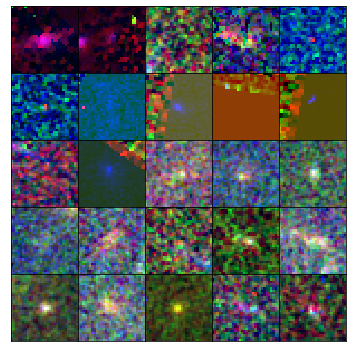

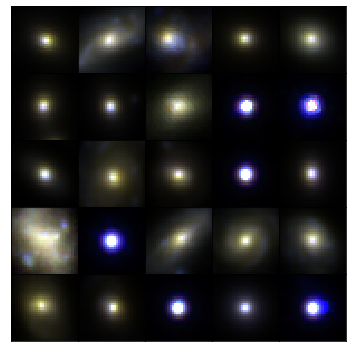

1


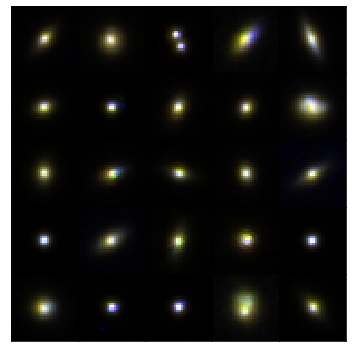

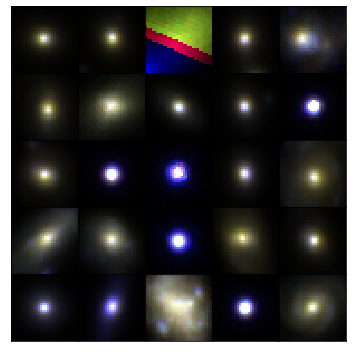

2


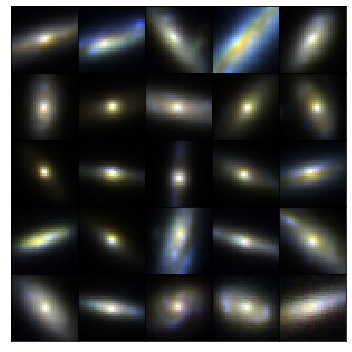

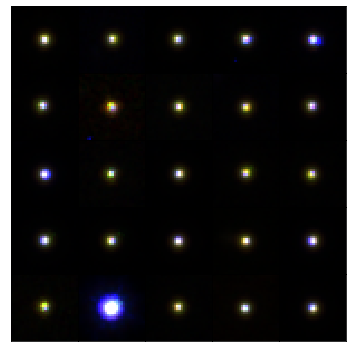

3


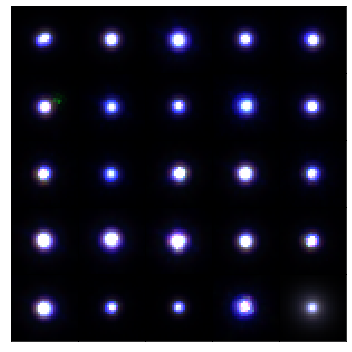

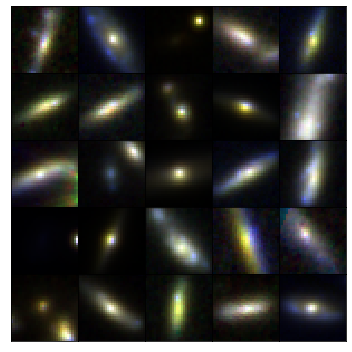

4


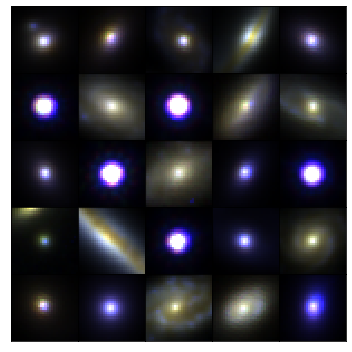

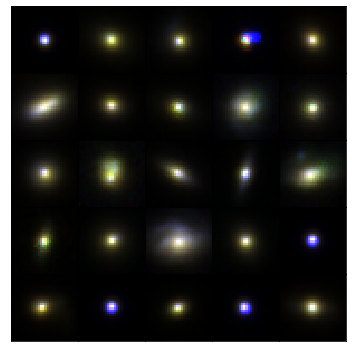

5


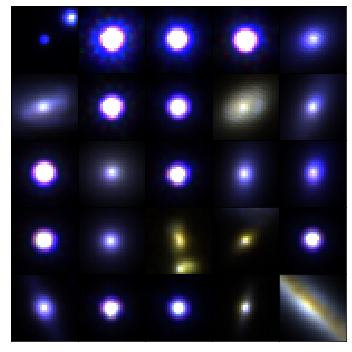

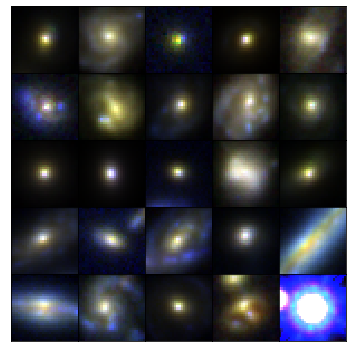

6


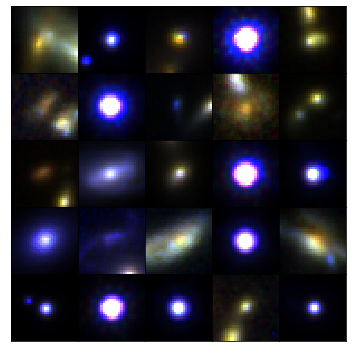

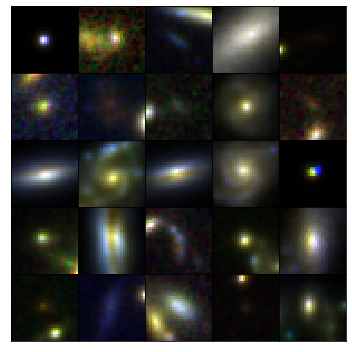

7


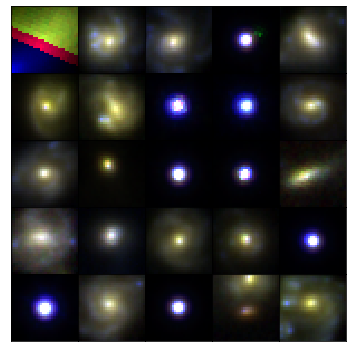

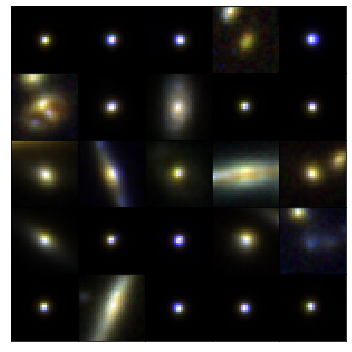

8


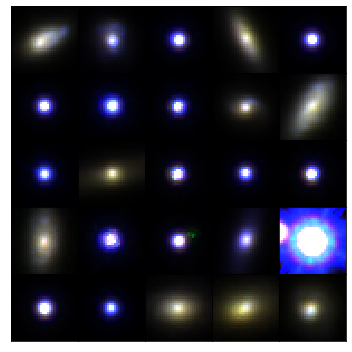

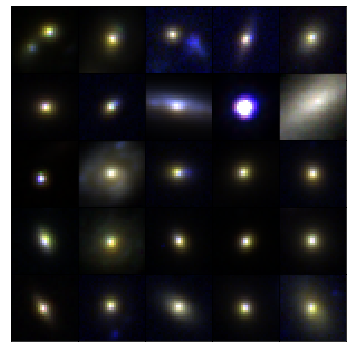

9


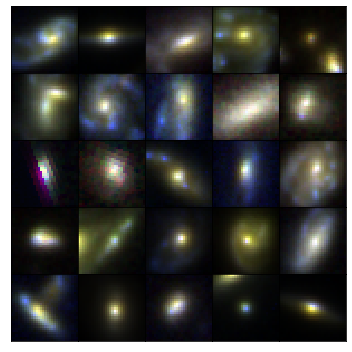

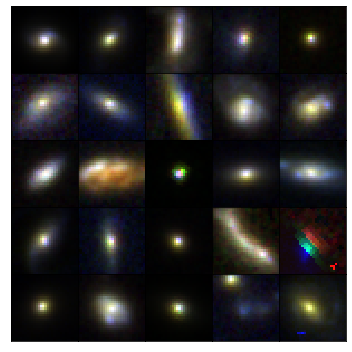

10


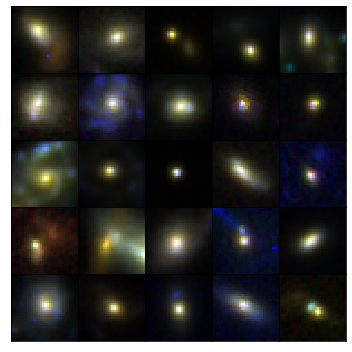

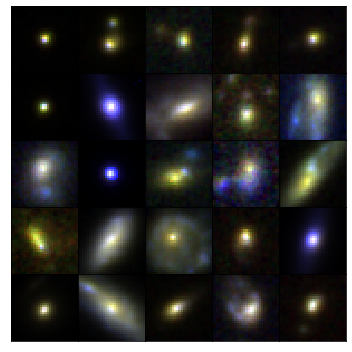

11


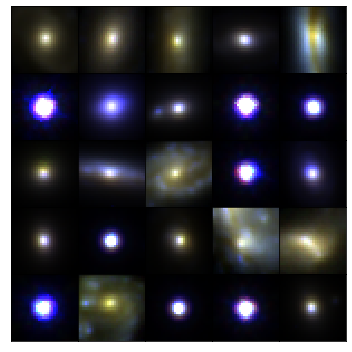

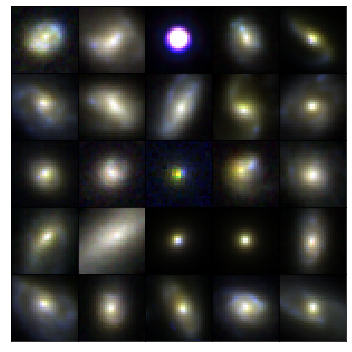

In [22]:
for i in range(0,scores.shape[1]):
    L,U=np.quantile(scores[:,i],[.01,.99])
    idxs=indexes[np.argsort(scores[:,i])]
    lower=indexes[np.argwhere(scores[:,i]<L)].flatten()
    lower=idxs[np.isin(idxs,lower)]
    upper=indexes[np.argwhere(scores[:,i]>U)].flatten()
    upper=idxs[np.isin(idxs,upper)]
    print(i)
    make_image(lower[0:30],(5,5)).show()
    make_image(upper[0:30],(5,5)).show()

# Imputing Values

22 within 10% 0.744140625


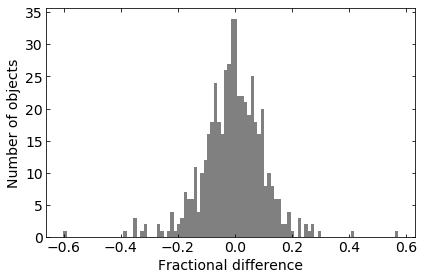

In [59]:
from pyppca import ppca
from sklearn.impute import SimpleImputer

np.random.seed(22)
cens_data=norm_data.copy()
miss_rows_idx=np.random.choice(indexes,int(len(norm_data)/20),replace=False)
for i in miss_rows_idx:
    d=cens_data[indexes==i].copy().reshape(SHP)
    off=np.random.choice([0,1,2],1)
    d[:,:,off]=np.nan
    cens_data[indexes==i]=d.flatten()
C,ss,M,X,y_ppca=ppca(cens_data,10,False)
inc_idx=np.isin(indexes,miss_rows_idx)
y_ppca=y_ppca[inc_idx]
real_sum=norm_data[inc_idx].sum(axis=1)
y_ppca_del=(norm_data[inc_idx]-y_ppca).sum(axis=1)
y_ppca_res=y_ppca_del/real_sum
less10=((y_ppca_res>=-.1)&(y_ppca_res<=.1)).sum()/len(y_ppca_res)
print("within 10%",less10) 

plt.hist(y_ppca_res,bins=100,color="gray")
plt.xlabel("Fractional difference", fontsize=14)
plt.ylabel("Number of objects", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in",which='minor')
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

plt.tight_layout()
#plt.savefig("recovery-pca.pdf")
plt.show()

In [ ]:
Example generation

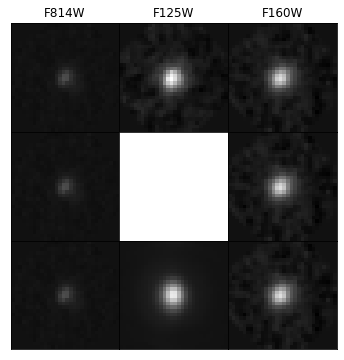

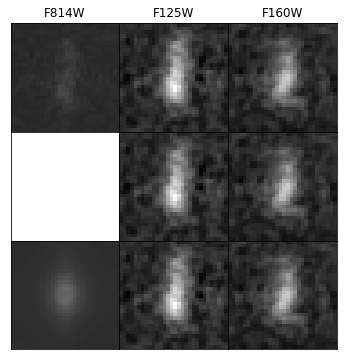

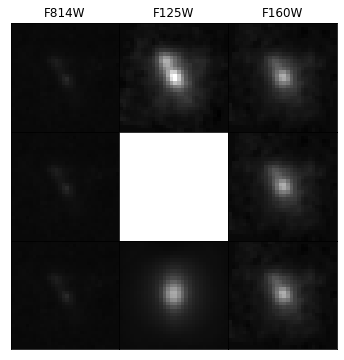

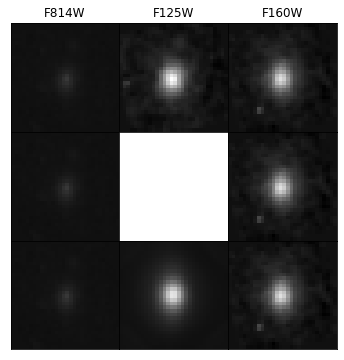

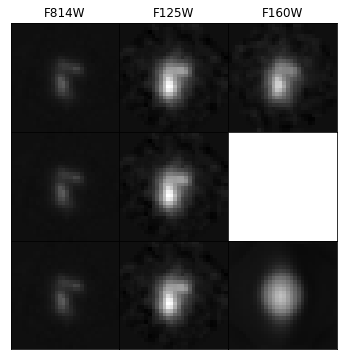

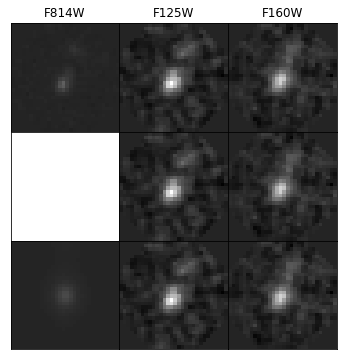

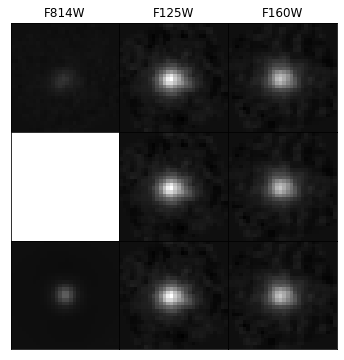

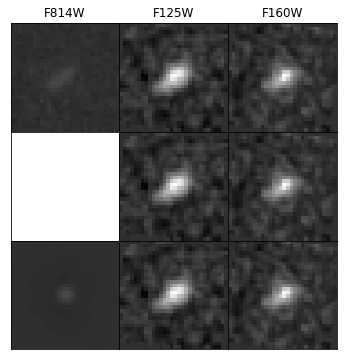

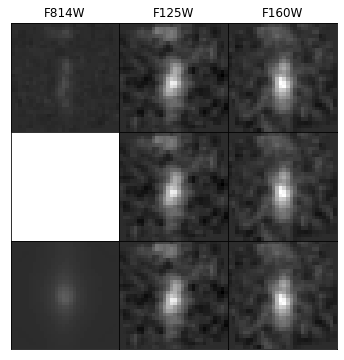

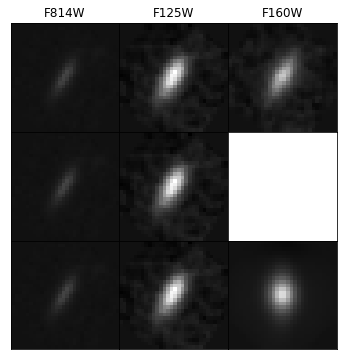

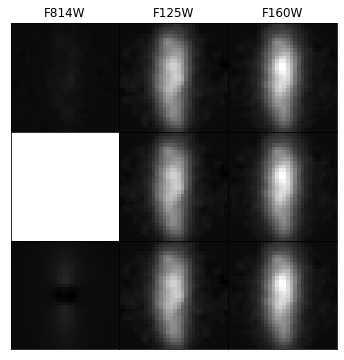

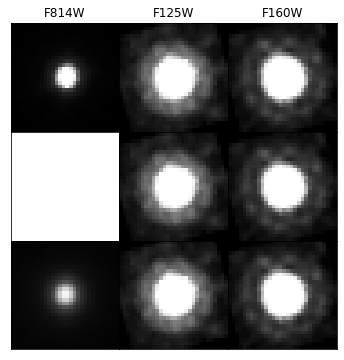

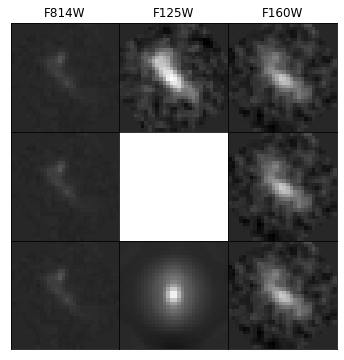

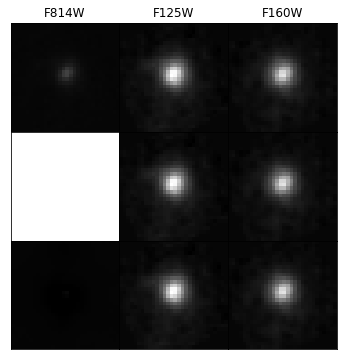

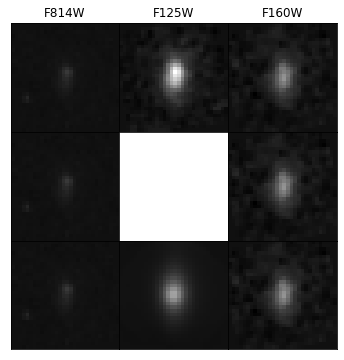

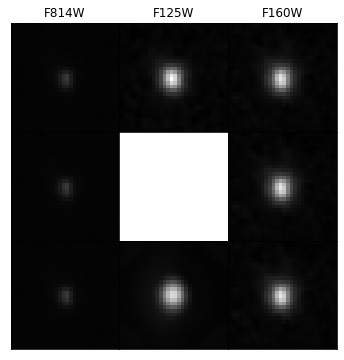

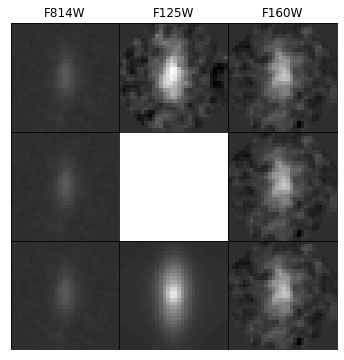

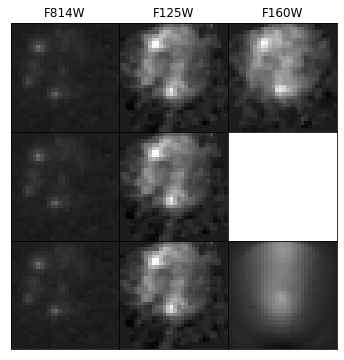

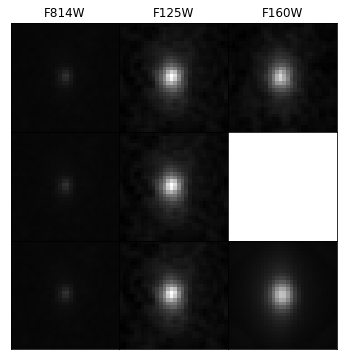

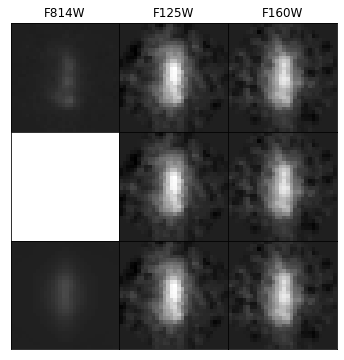

In [63]:
norm_samp=norm_data[inc_idx]
cens_samp=cens_data[inc_idx]
miss_rows_samp=np.random.choice(range(0,len(norm_samp)),20,replace=False)
for i in miss_rows_samp:
    L=[]
    x0=norm_samp[i].reshape(SHP)
    x1=cens_samp[i].reshape(SHP)
    x2=y_ppca[i].reshape(SHP)
    mn=x0.min();mx=x0.max()
    for k in BAND_ORDER: L.append(x0[:,:,k])
    for k in BAND_ORDER: L.append(x1[:,:,k])
    for k in BAND_ORDER: L.append(x2[:,:,k])
    fig=plt.figure(figsize=(3*2,3*2))
    grid=ImageGrid(fig,111,nrows_ncols=(3,3),axes_pad=0)
    for i,b in enumerate(BANDS): grid[i].set_title(b)
    for ax, im in zip(grid,L):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(im,cmap="gray",aspect="auto",vmin=mn,vmax=mx)
    plt.show()

# Image Query

Example generator for image queries.

/home/nodeuser/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


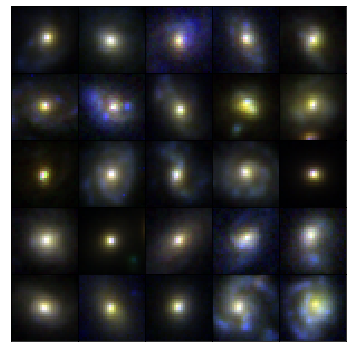

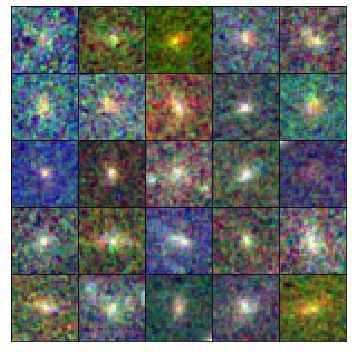

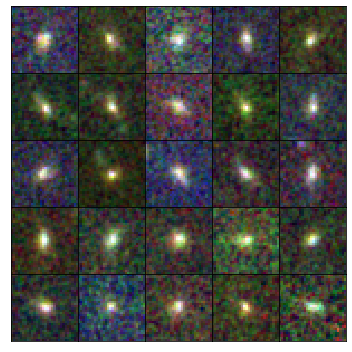

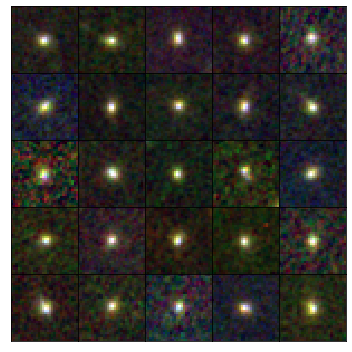

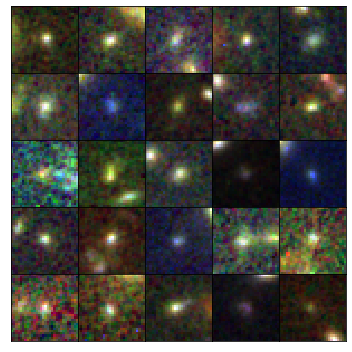

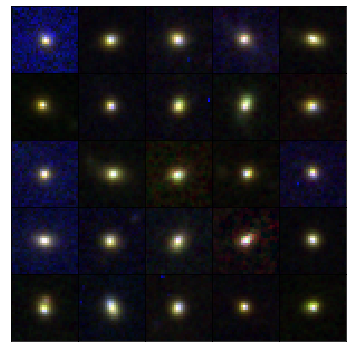

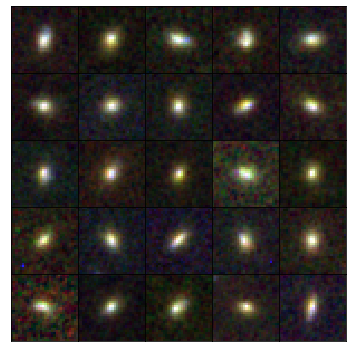

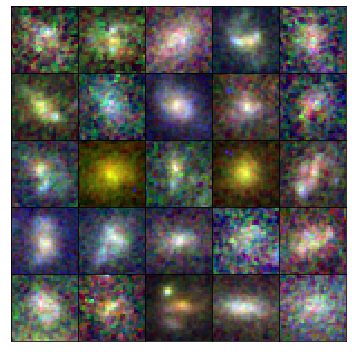

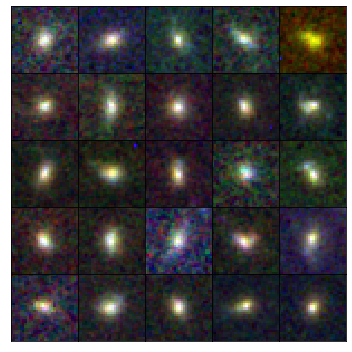

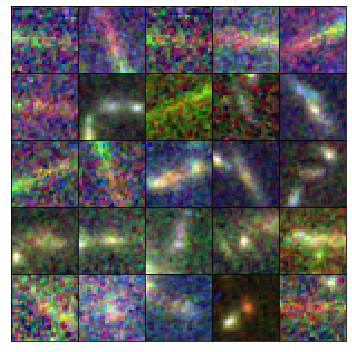

In [25]:
for z in range(0,10):
    np.random.seed(z+1000)
    ref_id=np.random.choice(range(0,len(scores)),1)
    ref=scores[ref_id]
    D=(((scores-ref)**2)**.5).sum(axis=1)
    D=pd.DataFrame(dict(v=D,i=indexes))
    D=D.sort_values("v").head(25)
    make_image(D.i.values,(5,5)).show()


# Affinity Propagation Clustering

In [ ]:
from sklearn.cluster import AffinityPropagation
clust=AffinityPropagation(damping=0.9,convergence_iter=100,max_iter=1000)
clust=clust.fit(scores)

In [ ]:
import os

l=clust.labels_
G=pd.DataFrame(dict(l=l)).groupby("l").l.count()
df=pd.DataFrame(dict(l=G.index,cnt=G.values))
df=df.sort_values("cnt",ascending=False)
df=df.head(100)

print("labels",len(np.unique(l)))
print("min",np.min(lbl_grp))
print("max",np.max(lbl_grp))
print("mean",np.median(lbl_grp))
print("median",np.median(lbl_grp))

for _,r in df.iterrows():
    print(r.l,int(r.cnt/10)+1)
    make_image(indexes[l==r.l],(int(r.cnt/10)+1,10)).savefig("clustering/%d.png" % r.l)
